In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [90]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools
from skimage.metrics import structural_similarity as ssim

Download the content and style images, and the pre-trained TensorFlow Lite models.

In [91]:
# content_path = tf.keras.utils.get_file('my.jpg','https://www.w3schools.com/w3images/lights.jpg')
# style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

content_path = '/content/drive/MyDrive/mist 4-2 sessional/cse444_pr/PR project/content/2.jpg'
style_path = '/content/drive/MyDrive/mist 4-2 sessional/cse444_pr/PR project/style/2.jpg'

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

## Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [92]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  # print('-------')
  # print(shape.numpy())
  # print(scale.numpy())
  # print(new_shape.numpy())
  # print('-------')
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)
print('Style Image Shape:', style_image.shape)
print('Content Image Shape:', content_image.shape)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessed Style Image Shape:', preprocessed_style_image.shape)
print('Preprocessed Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 640, 1024, 3)
Content Image Shape: (1, 474, 712, 3)
Preprocessed Style Image Shape: (1, 256, 256, 3)
Preprocessed Content Image Shape: (1, 384, 384, 3)


# Show the inputs

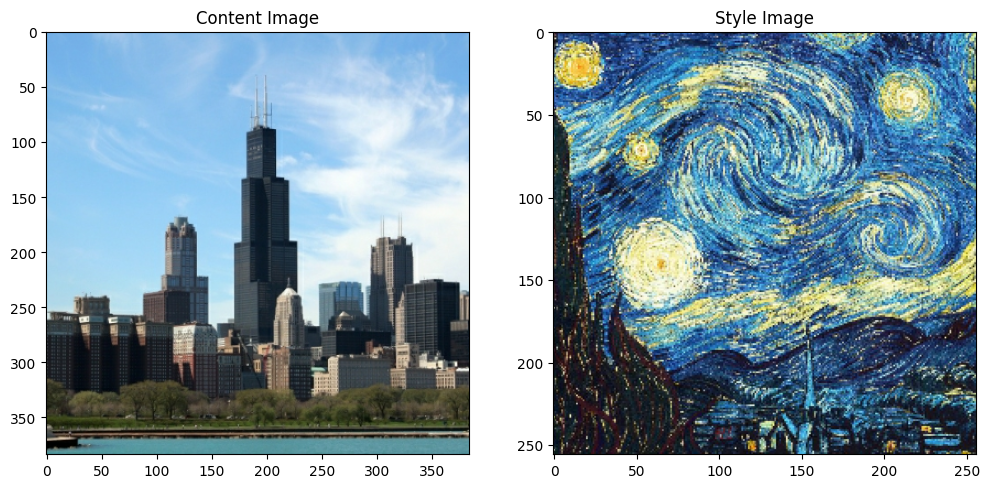

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')


### Style prediction

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  print(input_details)

  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

[{'name': 'style_image', 'index': 172, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Style Bottleneck Shape: (1, 1, 1, 100)


### Style transform

In [ ]:
# Run style transform on preprocessed style image with performance metrics
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=style_transform_path)

    # Set model input.
    input_details = interpreter.get_input_details()
    # print(input_details)
    interpreter.allocate_tensors()

    # Measure execution time
    start_cpu = time.process_time()
    start_wall = time.time()

    # Set model inputs.
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(
        interpreter.get_output_details()[0]["index"]
    )()

    end_cpu = time.process_time()
    end_wall = time.time()

    # Compute Total Loss (MSE)
    mse_loss = np.mean((preprocessed_content_image - stylized_image) ** 2)

    # Compute Structural Similarity Index (SSIM)
    # Convert TensorFlow tensors to NumPy arrays before SSIM calculation
    ssim_score = ssim(
        preprocessed_content_image.numpy().squeeze(),
        stylized_image.squeeze(),
        multichannel=True,
        data_range=1.0,
        win_size=3
    )

    # Time Taken
    cpu_time = end_cpu - start_cpu
    wall_time = end_wall - start_wall

    # Print Metrics
    print(f"Total Loss (MSE): {mse_loss:.6f}")
    print(f"Structural Similarity Index (SSIM): {ssim_score:.4f}")
    print(f"CPU Time: {cpu_time * 1e6:.2f} µs")
    print(f"Wall Time: {wall_time * 1e6:.2f} µs")

    return stylized_image


# # Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')


In [ ]:
# # Run style transform on preprocessed style image
# def run_style_transform(style_bottleneck, preprocessed_content_image):
#   # Load the model.
#   interpreter = tf.lite.Interpreter(model_path=style_transform_path)

#   # Set model input.
#   input_details = interpreter.get_input_details()
#   interpreter.allocate_tensors()

#   # Set model inputs.
#   interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
#   interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
#   interpreter.invoke()

#   # Transform content image.
#   stylized_image = interpreter.tensor(
#       interpreter.get_output_details()[0]["index"]
#       )()

#   return stylized_image

# # Stylize the content image using the style bottleneck.
# stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# # Visualize the output.
# imshow(stylized_image, 'Stylized Image')

### Style blending

In [ ]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

[{'name': 'style_image', 'index': 172, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Total Loss (MSE): 0.036718
Structural Similarity Index (SSIM): 0.5372
CPU Time: 568858.39 µs
Wall Time: 575794.70 µs


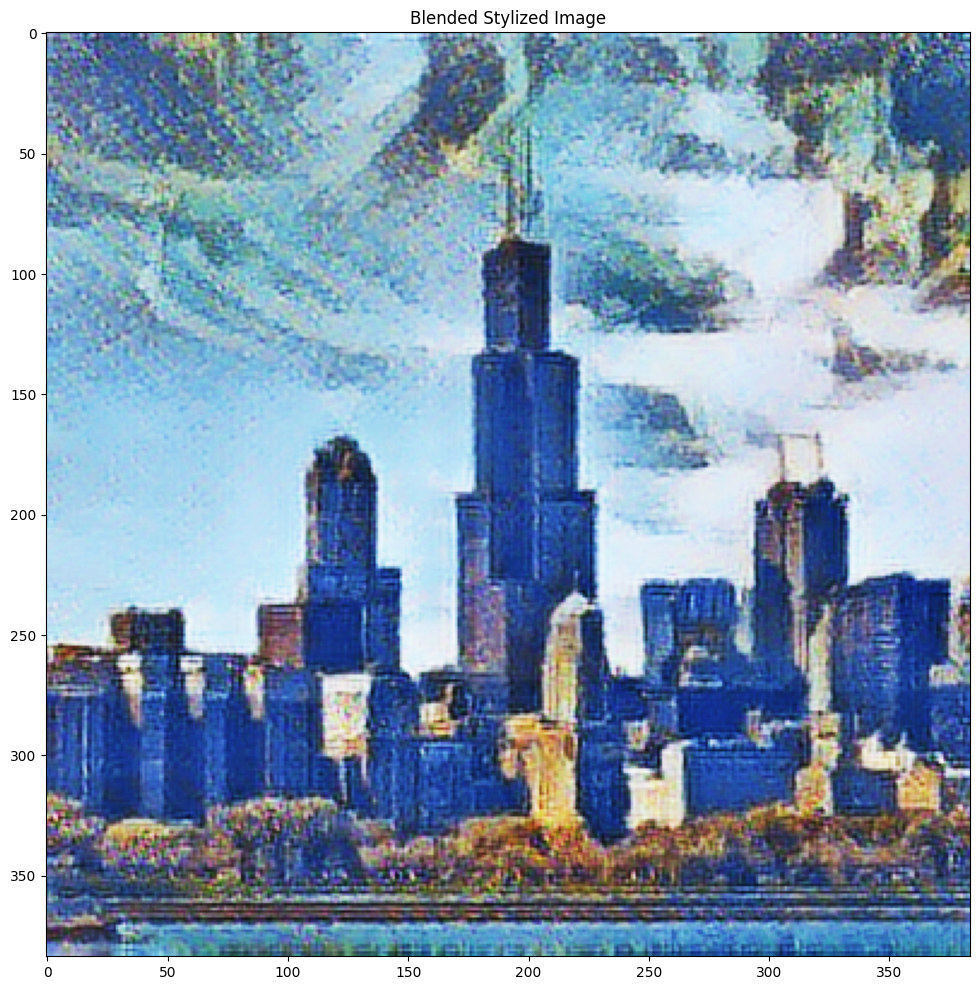

In [ ]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')